## Parte 1 - Instalando e importando bibliotecas que serão utilizadas

executar os códigos no terminal!

<code>conda create --yes --name workshop1 python=3.7</code>

<code>conda activate workshop1</code>

<code>conda install jupyterlab=2.2.6</code>

<code>conda install -c conda-forge pyproj=2.4.2.post1</code>

<code>conda install -c conda-forge descartes=1.1.0</code>

<code>conda install -c conda-forge geopandas=0.8.1</code>

<code>conda install -c conda-forge geopy=2.0.0</code>

<code>conda install pandas</code>

<code>conda install numpy</code>

<code>conda install matplotlib</code>

In [55]:
# importando bibliotecas que serao utilizadas
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj
import shapely.wkt
import seaborn as sns

## Parte 2 - Importando as informações do DataSet proposta para o projeto

In [56]:
# lendo o conjunto de dados
df = pd.read_csv('Real_State_Properati.csv', sep = '\t')
df_original = df.copy()

## Parte 3 - Entender o que cada coluna significa.

property_type : Tipo de propriedade.

place_name : Nome do bairro.

country_name : Nome do pais.

state_name: Localidade da propriedade.

lat : Latitude

lon : Longitude

price : Preco publicado na propaganda.

currency : tipo de moeda utilizada no anuncio.

surface_total_in_m2 : metragem da area do imovel.

In [57]:
# checando as primeiras linhas do conjunto
df.head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


## Após avaliar como os dados estão distribuídos no dataset, nota-se que não existem valores nulos.

In [58]:
# informação das colunas para ver se existem campos nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


## Convertendo os valores de habitação que estão precificados em Peso Argentino para Dólares dos EUA
Após avaliação inicial nota-se que grande parte das informações estão precificadas em USD

In [59]:
# convertendo preços com moeda ARS para USD

#1 ARS =  0.0085 USD

df['price_ajustado'] = df['price']

df['currency_ajustado'] = df['currency']

df.loc[df['currency']=='ARS', 'price_ajustado'] = df['price'] * 0.0085

df.loc[df['currency']=='ARS', 'currency_ajustado'] = df['currency'] = 'USD'

Criando o campo com os pontos plotados na Argentina

In [60]:
# criando o campo da geometria

df['geo'] = gpd.points_from_xy(df['lon'], df['lat'])
df.head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_ajustado,currency_ajustado,geo
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0,USD,POINT (-58.50884 -34.66182)
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0,USD,POINT (-58.52298 -34.65226)
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0,138000.0,USD,POINT (-58.44336 -34.55987)
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0,195000.0,USD,POINT (-58.44336 -34.55987)
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0,239000.0,USD,POINT (-58.50162 -34.65236)


## Avaliando distribuição dos dados.

## Nota-se que todos os nossos dados estão localizados na Argentina e em sua Capital Federal (Buenos Aires).

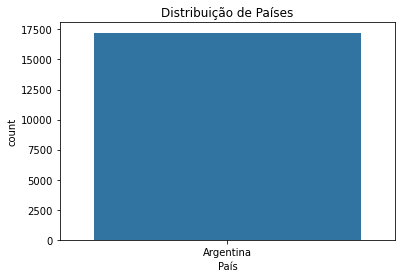

In [61]:
sns.countplot(data=df, x='country_name')
plt.title('Distribuição de Países')
plt.xlabel('País')
plt.show()

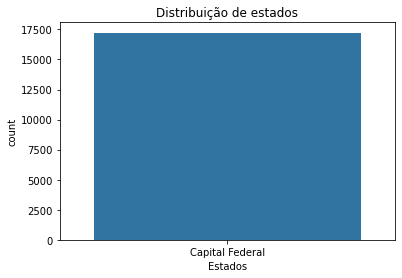

In [62]:
sns.countplot(data=df, x='state_name')
plt.title('Distribuição de estados')
plt.xlabel('Estados')
plt.show()

## Os dados das habitações estão concentrados em casas classificadas como "Apartamentos"

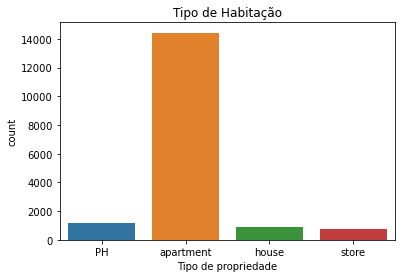

In [63]:
# grande parte dos imoveis estão concentrados em apartamentos
sns.countplot(data = df, x = 'property_type')
plt.title('Tipo de Habitação')
plt.xlabel('Tipo de propriedade')
plt.show()

## Nota-se que os valores dos apartamentos contém diversos outliers.

### As observações consideradas outliers serão removidas.

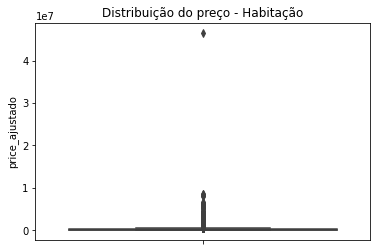

In [64]:
# distribuição do preço
sns.boxplot(data= df, y='price_ajustado')
plt.title('Distribuição do preço - Habitação')
plt.show()

In [ ]:
sns.boxplot(data= df, y='surface_total_in_m2')
plt.title('Distribuição do tamanho - Habitação')
plt.show()

## Para a remoção dos outliers será utilizado o método IQR (Interquartile Range)

### o IQR é uma medida de variabilidade dos dados que consiste em dividir os dados em quartis

In [65]:
# criando funcao que calcula os quartis e o IQR
# gera um novo data_frame com os outliers removidos
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

In [66]:
# removendo os outliers dos dados - preço ajustado
df_sem_outliers = remove_outlier_IQR(df.price_ajustado)

df_sem_outliers = pd.DataFrame(df_sem_outliers) # gerando um data frame para cruzar os indices e remover as informacoes selecionadas pelo iqr

ind_diff = df.index.difference(df_sem_outliers.index) # criando variavel que armazena a diferenca entre indices

# iterando o dataset e removendo os indices selecionados
for i in range(0, len(ind_diff), 1):
    df_final = df.drop([ind_diff[i]])
    df=df_final

print(f'foram removidos {len(ind_diff)} informações do dataset')

foram removidos 1729 informações do dataset


In [73]:
# removendo os outliers dos dados - tamanho da habitação
df_sem_outliers = remove_outlier_IQR(df.surface_total_in_m2)

df_sem_outliers = pd.DataFrame(df_sem_outliers) # gerando um data frame para cruzar os indices e remover as informacoes selecionadas pelo iqr

ind_diff = df.index.difference(df_sem_outliers.index) # criando variavel que armazena a diferenca entre indices

# iterando o dataset e removendo os indices selecionados
for i in range(0, len(ind_diff), 1):
    df_final = df.drop([ind_diff[i]])
    df=df_final

print(f'foram removidos {len(ind_diff)} informações do dataset')

foram removidos 1155 informações do dataset


In [76]:
print(df_final.shape)
print(df.shape)

(14339, 12)
(14339, 12)


## Checando a distribuição das colunas que foram tratadas através do IQR

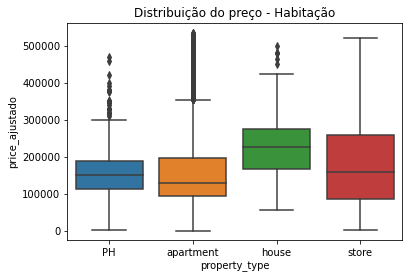

In [80]:
sns.boxplot(data = df_final,
            y = 'price_ajustado',
            x = 'property_type')
plt.title('Distribuição do preço - Habitação')
plt.show()

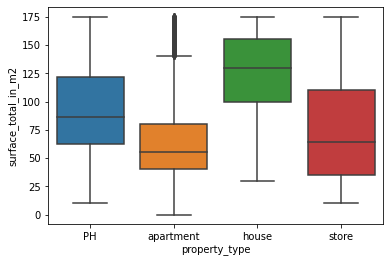

In [82]:
sns.boxplot(
    data = df_final,
    y = 'surface_total_in_m2',
    x = 'property_type'
)
plt.show()

## Checando a correlação das variáveis "área total da habitação em M2" e "preço convertido"

<AxesSubplot:xlabel='price_ajustado', ylabel='surface_total_in_m2'>

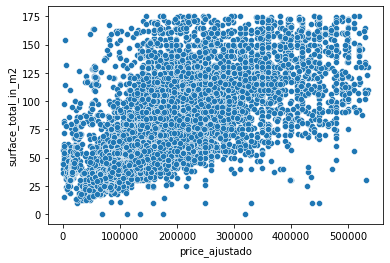

In [84]:
sns.scatterplot(
    data=df_final,
    y = 'surface_total_in_m2',
    x = 'price_ajustado'
)